In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from refractive_index import ciddor, edlen
from Mathar2007 import n

# Publication color scheme
PUB_GRAY = '#cecece'
PUB_PURPLE = '#a559aa'
PUB_TEAL = '#59a89c'
PUB_GOLD = '#f0c571'
PUB_RED = '#e02b35'
PUB_BLUE = '#082a54'

def setup_publication_style():
    """
    Configure matplotlib parameters for publication-quality figures.
    
    This function sets up consistent styling for all plots including:
    - Font settings and mathematical typesetting
    - Figure size and resolution
    - Axis properties and grid styling
    - Line and marker properties
    - Tick direction and minor ticks
    - Legend styling
    - Save figure defaults
    """
    plt.rcParams.update({
        'font.size': 16,
        'font.family': 'Helvetica',
        'mathtext.fontset': 'stix',
        
        'figure.figsize': [10, 6],
        'figure.dpi': 300,
        
        'axes.linewidth': 1.2,
        'axes.labelsize': 16,
        'axes.grid': True,
        'axes.titlesize': 16,
        
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'lines.markeredgewidth': 1,
        
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.minor.visible': True,
        'ytick.minor.visible': True,
        
        'legend.fontsize': 16,
        'legend.frameon': True,
        'legend.fancybox': True,
        'legend.shadow': False,
        'legend.framealpha': 0.95,
        
        'savefig.bbox': 'tight',
        'savefig.dpi': 300,
        'savefig.format': 'pdf'
    })
    
def n_1762_model(T, H, P):
    """
    AcToMicS refractive index model for 1762 nm.
    
    Parameters:
    -----------
    T : float or array-like
        Temperature in °C
    H : float or array-like  
        Humidity in %
    P : float or array-like
        Pressure in Pa
        
    Returns:
    --------
    float or array-like
        Refractive index at 1762 nm
    """
    return 1.000027 - 8.94e-07 * T - 1.78e-08 * H + 2.569e-09 * P

def calculate_slope(x, y):
    """
    Calculate linear slope using polynomial fitting.
    
    Parameters:
    -----------
    x : array-like
        Independent variable
    y : array-like
        Dependent variable
        
    Returns:
    --------
    float
        Slope of the linear fit
    """
    slope, _ = np.polyfit(x, y, 1)
    return slope

def compare_refractive_index_models(wavelength=1762, save_path='refractive_index_comparison.pdf'):
    """
    Compare different refractive index models for environmental dependence.
    
    Parameters:
    -----------
    wavelength : float, optional
        Wavelength in nm (default: 1762)
    save_path : str, optional
        Path to save the output figure
        
    Returns:
    --------
    tuple
        (figure_object, statistics_dict)
    """
    # Setup publication style
    setup_publication_style()
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.subplots_adjust(wspace=0.3)
    
    # Define standard conditions
    standard_conditions = {
        'pressure': 99000,    # Pa
        'humidity': 30,       # %
        'temperature': 30     # °C
    }
    
    # Storage for statistics
    statistics = {}
    
    # Panel 1: Temperature comparison
    print("=== TEMPERATURE DEPENDENCE ===")
    pressure = standard_conditions['pressure']
    humidity = standard_conditions['humidity']
    temperature_range = np.linspace(20, 30, 1000)
    
    models_temp = {
        'NIST Ciddor': np.array([ciddor(wave=wavelength, t=t, p=pressure, rh=humidity) 
                                for t in temperature_range]),
        'NIST Edlén': np.array([edlen(wave=wavelength, t=t, p=pressure, rh=humidity) 
                               for t in temperature_range]),
        'Mathar 2007': n(wavelength/1000, 273.15 + temperature_range, pressure, humidity),
        'AcToMicS': n_1762_model(temperature_range, humidity, pressure)
    }
    
    # Plot temperature comparison
    colors = [PUB_PURPLE, PUB_TEAL, PUB_GOLD, PUB_BLUE]
    for i, (label, values) in enumerate(models_temp.items()):
        axes[0].plot(temperature_range, values, label=label, color=colors[i], linewidth=2)
        
        # Calculate and store slope
        slope = calculate_slope(temperature_range, values)
        statistics[f'{label}_temp_slope'] = slope
        print(f"{label}: dN/dT = {slope:.3e}")
    
    axes[0].set_xlabel('Temperature (°C)')
    axes[0].set_ylabel('Refractive Index')
    axes[0].set_title('Temperature Dependence')
    axes[0].grid(True, alpha=0.3)
    axes[0].text(0.05, 0.95, '(a)', transform=axes[0].transAxes, va='top', ha='left')
    
    # Panel 2: Humidity comparison
    print("\n=== HUMIDITY DEPENDENCE ===")
    temperature = standard_conditions['temperature']
    humidity_range = np.linspace(20, 40, 1000)
    
    models_humidity = {
        'NIST Ciddor': np.array([ciddor(wave=wavelength, t=temperature, p=pressure, rh=h) 
                                for h in humidity_range]),
        'NIST Edlén': np.array([edlen(wave=wavelength, t=temperature, p=pressure, rh=h) 
                               for h in humidity_range]),
        'Mathar 2007': n(wavelength/1000, 273.15 + temperature, pressure, humidity_range),
        'AcToMicS': n_1762_model(temperature, humidity_range, pressure)
    }
    
    # Plot humidity comparison
    for i, (label, values) in enumerate(models_humidity.items()):
        axes[1].plot(humidity_range, values, label=label, color=colors[i], linewidth=2)
        
        # Calculate and store slope
        slope = calculate_slope(humidity_range, values)
        statistics[f'{label}_humidity_slope'] = slope
        print(f"{label}: dN/dH = {slope:.3e}")
    
    axes[1].set_xlabel('Humidity (%)')
    axes[1].set_title('Humidity Dependence')
    axes[1].grid(True, alpha=0.3)
    axes[1].text(0.05, 0.95, '(b)', transform=axes[1].transAxes, va='top', ha='left')
    
    # Panel 3: Pressure comparison
    print("\n=== PRESSURE DEPENDENCE ===")
    pressure_range = np.linspace(95000, 110000, 1000)
    
    models_pressure = {
        'NIST Ciddor': np.array([ciddor(wave=wavelength, t=temperature, p=p, rh=humidity) 
                                for p in pressure_range]),
        'NIST Edlén': np.array([edlen(wave=wavelength, t=temperature, p=p, rh=humidity) 
                               for p in pressure_range]),
        'Mathar 2007': n(wavelength/1000, 273.15 + temperature, pressure_range, humidity),
        'AcToMicS': n_1762_model(temperature, humidity, pressure_range)
    }
    
    # Plot pressure comparison
    for i, (label, values) in enumerate(models_pressure.items()):
        axes[2].plot(pressure_range, values, label=label, color=colors[i], linewidth=2)
        
        # Calculate and store slope
        slope = calculate_slope(pressure_range, values)
        statistics[f'{label}_pressure_slope'] = slope
        print(f"{label}: dN/dP = {slope:.3e}")
    
    axes[2].set_xlabel('Pressure (Pa)')
    axes[2].set_title('Pressure Dependence')
    axes[2].grid(True, alpha=0.3)
    axes[2].text(0.05, 0.95, '(c)', transform=axes[2].transAxes, va='top', ha='left')
    
    # Add legends to all subplots
    for ax in axes:
        ax.legend(loc='best', framealpha=0.9)
    
    # Add overall title
    plt.suptitle(f'Refractive Index Model Comparison at {wavelength} nm', 
                y=1.05, fontsize=16, fontweight='bold')
    
    # Save figure
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Print summary statistics
    print("\n=== SUMMARY STATISTICS ===")
    print("Model comparison completed successfully!")
    print(f"Figure saved as: {save_path}")
    
    return fig, statistics

def create_sensitivity_comparison_table(statistics):
    """
    Create a formatted table comparing model sensitivities.
    
    Parameters:
    -----------
    statistics : dict
        Dictionary containing slope statistics from compare_refractive_index_models
        
    Returns:
    --------
    pandas.DataFrame
        Formatted comparison table
    """
    # Extract model names
    models = ['NIST Ciddor', 'NIST Edlén', 'Mathar 2007', 'AcToMicS']
    
    # Create comparison table
    comparison_data = []
    for model in models:
        temp_slope = statistics.get(f'{model}_temp_slope', np.nan)
        humidity_slope = statistics.get(f'{model}_humidity_slope', np.nan)
        pressure_slope = statistics.get(f'{model}_pressure_slope', np.nan)
        
        comparison_data.append({
            'Model': model,
            'dN/dT (K⁻¹)': f"{temp_slope:.2e}",
            'dN/dH (%⁻¹)': f"{humidity_slope:.2e}", 
            'dN/dP (Pa⁻¹)': f"{pressure_slope:.2e}"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n=== SENSITIVITY COMPARISON TABLE ===")
    print(comparison_df.to_string(index=False))
    print("=" * 50)
    
    return comparison_df

=== TEMPERATURE DEPENDENCE ===
NIST Ciddor: dN/dT = -8.872e-07
NIST Edlén: dN/dT = -8.872e-07
Mathar 2007: dN/dT = -8.891e-07
AcToMicS: dN/dT = -8.940e-07

=== HUMIDITY DEPENDENCE ===
NIST Ciddor: dN/dH = -1.537e-08
NIST Edlén: dN/dH = -1.526e-08
Mathar 2007: dN/dH = -1.653e-08
AcToMicS: dN/dH = -1.780e-08

=== PRESSURE DEPENDENCE ===
NIST Ciddor: dN/dP = 2.562e-09
NIST Edlén: dN/dP = 2.563e-09
Mathar 2007: dN/dP = 2.562e-09
AcToMicS: dN/dP = 2.569e-09

=== SUMMARY STATISTICS ===
Model comparison completed successfully!
Figure saved as: ../figures/refractive_index_comparison.pdf

=== SENSITIVITY COMPARISON TABLE ===
      Model dN/dT (K⁻¹) dN/dH (%⁻¹) dN/dP (Pa⁻¹)
NIST Ciddor   -8.87e-07   -1.54e-08     2.56e-09
 NIST Edlén   -8.87e-07   -1.53e-08     2.56e-09
Mathar 2007   -8.89e-07   -1.65e-08     2.56e-09
   AcToMicS   -8.94e-07   -1.78e-08     2.57e-09


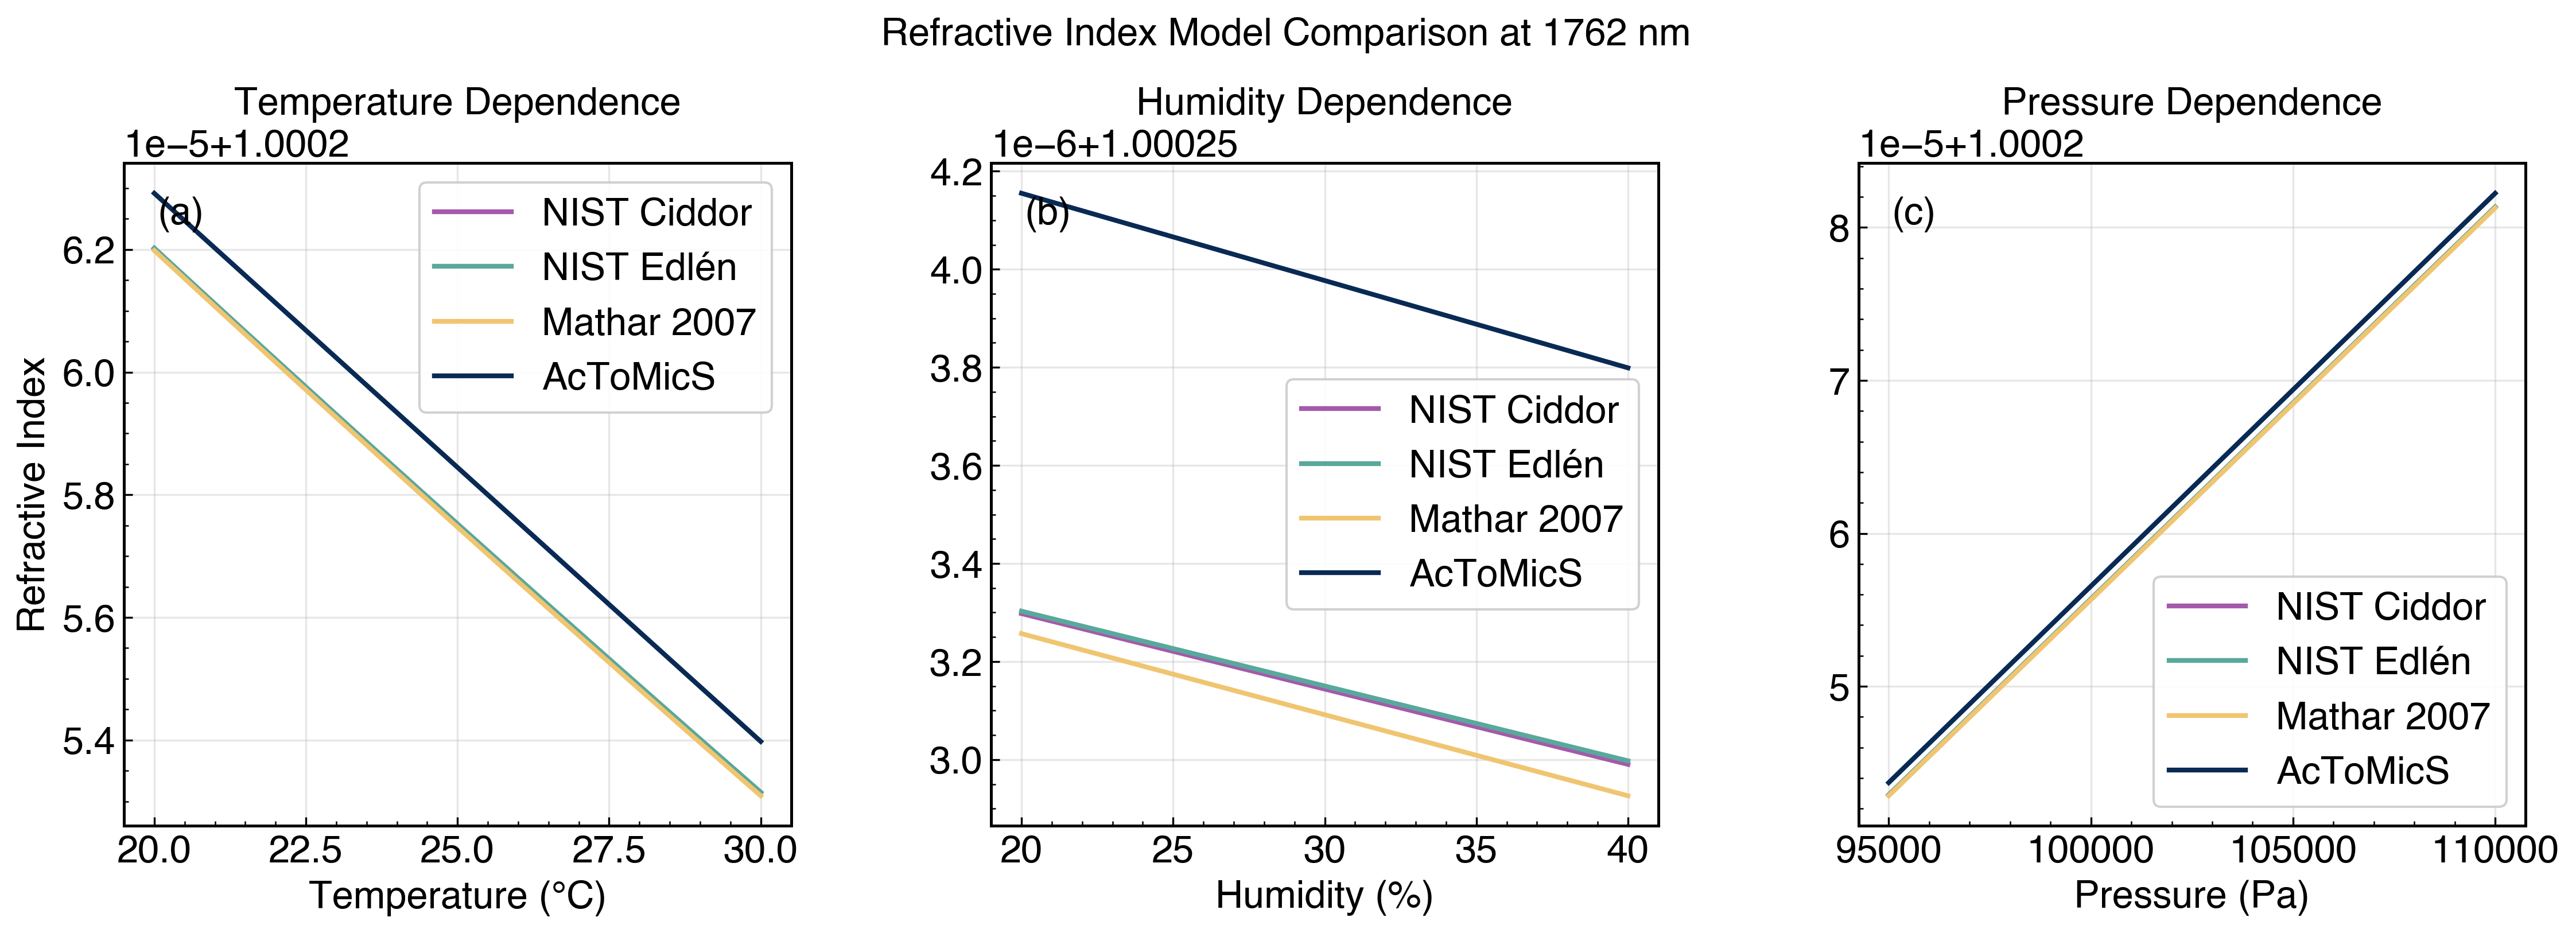

In [4]:
# Compare refractive index models
fig, stats = compare_refractive_index_models(
    wavelength=1762,
    save_path='../figures/refractive_index_comparison.pdf'
)

# Create sensitivity comparison table
comparison_table = create_sensitivity_comparison_table(stats)

plt.show()
